In [1]:
# =======================================================================
# CELDA 1: Instalación de todas las dependencias (Versión Modelo Large)
# =======================================================================
print("Instalando bibliotecas necesarias...")
!pip install -q segment-anything-py
!pip install -q google-cloud-vision
!pip install -q opencv-python-headless matplotlib

# --- CAMBIO AQUÍ ---
# Borramos el modelo 'base' si ya existía
!rm -f sam_vit_b_01ec64.pth

# Descargamos el modelo "vit_l" (large)
print("Descargando modelo SAM 'large' (vit_l)... 1.2GB")
!wget -q https://dl.fbaipublicfiles.com/segment_anything/sam_vit_l_0b3195.pth
# --- FIN DEL CAMBIO ---

print("Instalación completa.")

Instalando bibliotecas necesarias...
Descargando modelo SAM 'large' (vit_l)... 1.2GB
Instalación completa.


In [2]:
# =======================================================================
# CELDA 2: Autenticación
# =======================================================================
import os
from google.colab import files

print("Por favor, sube tu NUEVO archivo JSON de credenciales de Google Cloud.")

uploaded_files = files.upload()

# Obtener el nombre del archivo subido y configurar la variable de entorno
if not uploaded_files:
    print("\n¡No se subió ningún archivo! Ejecuta la celda de nuevo.")
else:
    json_key_filename = list(uploaded_files.keys())[0]
    os.environ["GOOGLE_APPLICATION_CREDENTIALS"] = json_key_filename
    print(f"\nArchivo '{json_key_filename}' subido y autenticación configurada.")

Por favor, sube tu NUEVO archivo JSON de credenciales de Google Cloud.


Saving gen-lang-client-0027328417-65ea74948f12.json to gen-lang-client-0027328417-65ea74948f12 (1).json

Archivo 'gen-lang-client-0027328417-65ea74948f12 (1).json' subido y autenticación configurada.


In [3]:
# =======================================================================
# CELDA 3: Montar Google Drive
# =======================================================================
from google.colab import drive

print("Conectando con Google Drive...")
drive.mount('/content/drive')
print("Google Drive montado en /content/drive")

Conectando con Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Google Drive montado en /content/drive


In [4]:
# =======================================================================
# CELDA 4: Definición de la ruta del archivo
# =======================================================================
import os

# Esta es la ruta que proporcionaste
map_image_path = "/content/drive/MyDrive/0.- Archivos/Software/Proyecto digitalizacion geologica/prueb1.png"

if os.path.exists(map_image_path):
    print(f"Archivo de mapa encontrado en: {map_image_path}")
else:
    print(f"¡ERROR! No se pudo encontrar el archivo en: {map_image_path}")
    print("Verifica que el nombre y la ruta en tu Drive sean correctos.")

Archivo de mapa encontrado en: /content/drive/MyDrive/0.- Archivos/Software/Proyecto digitalizacion geologica/prueb1.png


In [5]:
# =======================================================================
# CELDA 5: Carga de Modelos y Funciones Principales (Versión Modelo Large)
# =======================================================================
import cv2
import matplotlib.pyplot as plt
import numpy as np
import torch
from segment_anything import SamAutomaticMaskGenerator, sam_model_registry
from google.cloud import vision

# --- 1. Función de OCR (Cloud Vision) ---
# (Esta función no cambia)
def get_text_from_roi(image_data):
    try:
        client = vision.ImageAnnotatorClient()
        image = vision.Image(content=image_data)
        response = client.text_detection(image=image)
        texts = response.text_annotations
        if texts:
            detected_text = texts[0].description.replace('\n', ' ').strip()
            return detected_text
        else:
            return None
    except Exception as e:
        print(f"Error en la API de Vision: {e}")
        return None

# --- 2. Carga del modelo SAM (CAMBIOS AQUÍ) ---
print("Cargando modelo SAM 'large' (vit_l)... (esto puede tardar más)")

# --- CAMBIO 1: Usar "vit_l" ---
sam = sam_model_registry["vit_l"](checkpoint="sam_vit_l_0b3195.pth") # --- CAMBIO 2: Usar el nuevo archivo ---

# Mover el modelo a la GPU de Colab
sam.to(device="cuda" if torch.cuda.is_available() else "cpu")

# Configurar el generador automático de máscaras
# (Los parámetros se mantienen, puedes ajustarlos si quieres)
mask_generator = SamAutomaticMaskGenerator(
    model=sam,
    points_per_side=16,
    pred_iou_thresh=0.86,
    min_mask_region_area=1000
)
print("Modelo SAM 'large' cargado.")

Cargando modelo SAM 'large' (vit_l)... (esto puede tardar más)
Modelo SAM 'large' cargado.


In [6]:
# =======================================================================
# CELDA 6.1: Carga y Preprocesamiento
# =======================================================================

# Asegurarse de que cv2 esté importado (ya debería estarlo por la celda 5)
import cv2
import numpy as np

print(f"Cargando imagen: {map_image_path}")
# Cargar la imagen con OpenCV
image_bgr = cv2.imread(map_image_path)

if image_bgr is None:
    print("Error al cargar la imagen. Verifica la ruta.")
else:
    # Guardamos la imagen original en RGB (para el OCR y la visualización)
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # --- INICIO DE PREPROCESAMIENTO ---
    print("Iniciando preprocesamiento (CLAHE)...")

    # 1. Convertir a escala de grises
    image_gray = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2GRAY)

    # 2. Aplicar CLAHE (Contrast Limited Adaptive Histogram Equalization)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
    image_processed_gray = clahe.apply(image_gray) # Esta es la salida en 1 canal

    # 3. Convertir la imagen procesada a 3 canales (RGB) para SAM
    # SAM espera una entrada de 3 canales (RGB), así que duplicamos el canal gris.
    image_sam_input = cv2.cvtColor(image_processed_gray, cv2.COLOR_GRAY2RGB)

    print("Preprocesamiento completado.")
    print("Variables listas: 'image_rgb' (Original), 'image_sam_input' (Procesada para SAM)")
    # --- FIN DE PREPROCESAMIENTO ---

Cargando imagen: /content/drive/MyDrive/0.- Archivos/Software/Proyecto digitalizacion geologica/prueb1.png
Iniciando preprocesamiento (CLAHE)...
Preprocesamiento completado.
Variables listas: 'image_rgb' (Original), 'image_sam_input' (Procesada para SAM)


Mostrando comparación (Original vs. Procesada para SAM)...


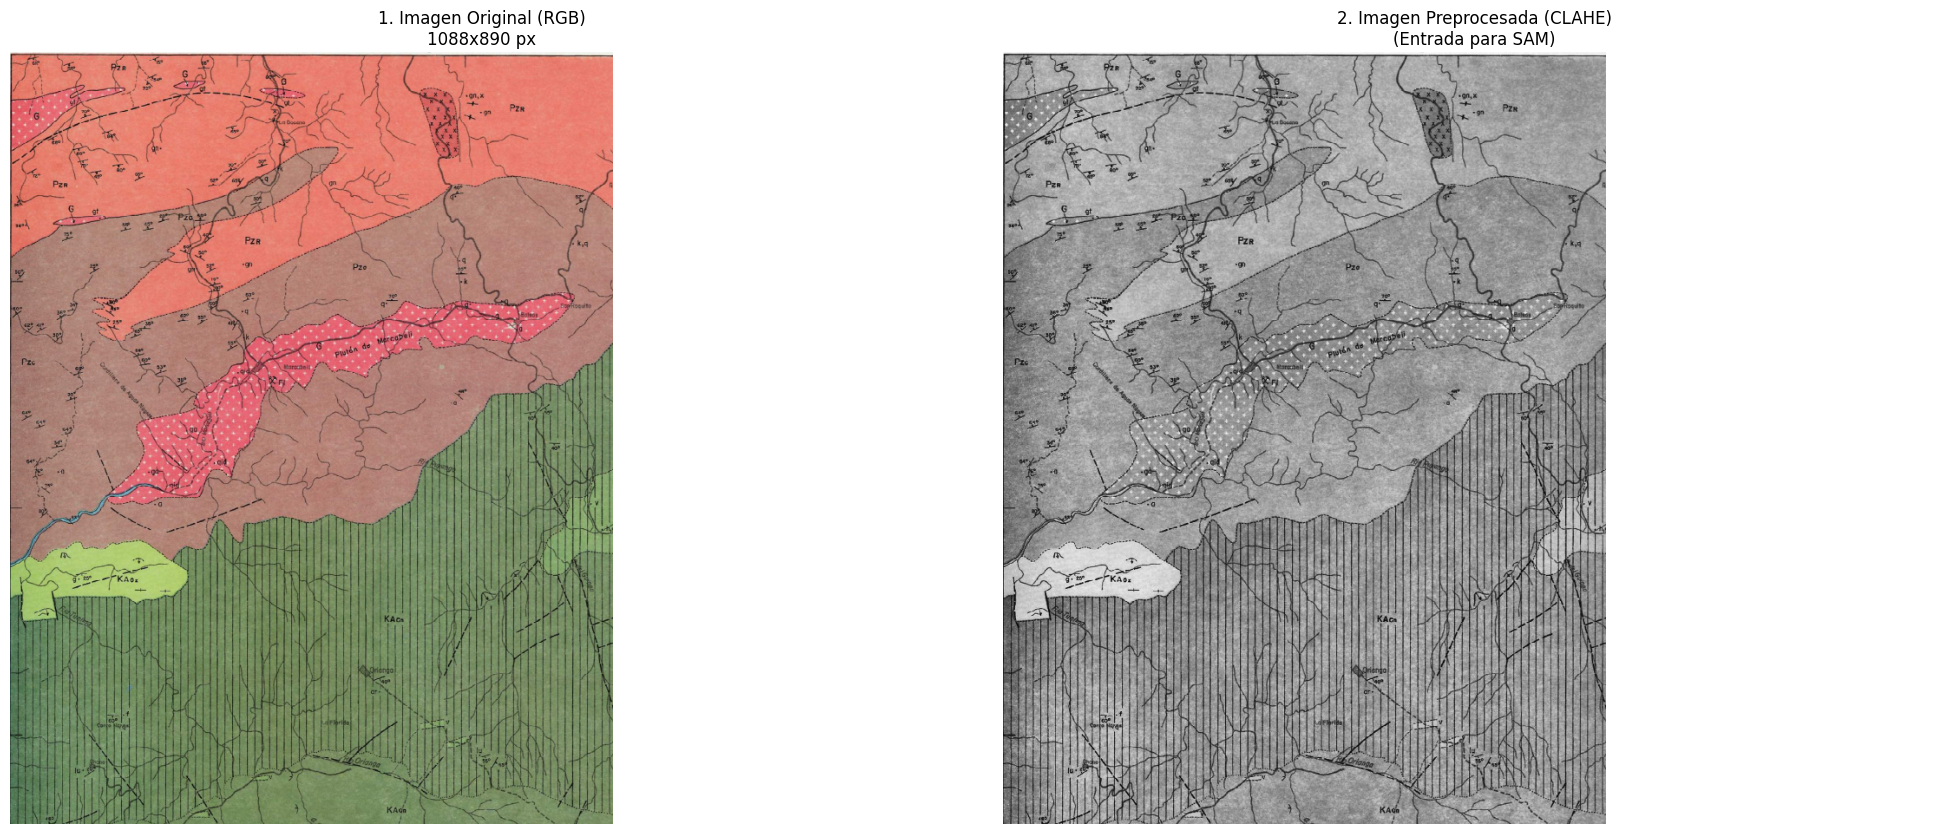

In [7]:
# =======================================================================
# CELDA 6.2: Visualización del Preprocesamiento
# =======================================================================

# Asegurarse de que plt esté importado (ya debería estarlo por la celda 5)
import matplotlib.pyplot as plt

if 'image_rgb' not in locals():
    print("Error: Ejecuta la celda 6.1 primero.")
else:
    print("Mostrando comparación (Original vs. Procesada para SAM)...")

    # Configurar el tamaño de la figura (será grande)
    # Ajustamos el aspect ratio basado en las dimensiones de la imagen
    height, width, _ = image_rgb.shape
    aspect_ratio = height / width

    # Definimos un ancho de figura y calculamos el alto
    fig_width = 20 # Ancho total en pulgadas para 2 imágenes
    fig_height = (fig_width / 2) * aspect_ratio

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(fig_width, fig_height))

    # Imagen Original
    ax1.imshow(image_rgb)
    ax1.set_title(f"1. Imagen Original (RGB)\n{width}x{height} px")
    ax1.axis('off')

    # Imagen Procesada (la que verá SAM)
    ax2.imshow(image_sam_input)
    ax2.set_title(f"2. Imagen Preprocesada (CLAHE)\n(Entrada para SAM)")
    ax2.axis('off')

    plt.tight_layout()
    plt.show()

In [8]:
# =======================================================================
# CELDA 6.3: Ejecución SAM + Vision
# =======================================================================

if 'image_sam_input' not in locals():
    print("Error: Ejecuta la celda 6.1 primero.")
else:
    print("Iniciando segmentación con SAM (esto puede tardar mucho en una imagen grande)...")

    # 1. SEGMENTACIÓN (SAM)
    # Alimentamos a SAM con la imagen preprocesada (image_sam_input)
    masks = mask_generator.generate(image_sam_input)
    print(f"SAM encontró {len(masks)} polígonos/segmentos.")

    resultados = [] # Aquí guardaremos {bbox, texto}

    # 2. OCR (Vision API) por cada máscara
    print("Iniciando reconocimiento de texto (OCR) en cada polígono...")

    for i, mask_data in enumerate(masks):
        # 'bbox' es [x_min, y_min, width, height]
        [x, y, w, h] = mask_data['bbox']

        # IMPORTANTE: Recortamos el polígono de la imagen ORIGINAL (image_rgb)
        recorte_rgb = image_rgb[y:y+h, x:x+w]

        # Convertir el recorte a formato de bytes (PNG) para la API
        _, buffer = cv2.imencode('.png', cv2.cvtColor(recorte_rgb, cv2.COLOR_RGB2BGR))
        image_bytes = buffer.tobytes()

        # 3. Llamar a la API de Vision con el recorte
        texto_detectado = get_text_from_roi(image_bytes)

        if texto_detectado:
            print(f"  Polígono {i}: BBox[{x},{y}] -> Texto: '{texto_detectado}'")
            # Guardamos el resultado
            resultados.append({
                "bbox": mask_data['bbox'],
                "text": texto_detectado
            })

    print("Procesamiento completado.")

Iniciando segmentación con SAM (esto puede tardar mucho en una imagen grande)...
SAM encontró 14 polígonos/segmentos.
Iniciando reconocimiento de texto (OCR) en cada polígono...
  Polígono 1: BBox[0,563] -> Texto: '"KA'
  Polígono 2: BBox[471,41] -> Texto: '2 x x XXX x x'
  Polígono 6: BBox[486,189] -> Texto: '-k'
  Polígono 8: BBox[0,4] -> Texto: '시 PZR Pzc PZR gn. La Dosan .gn,x + G gt Pzo PZR gn ड Cordillene de Agda Nage Pze Marcobell Plutón de Mercabe ΚΑΘΕ KACA ar- Orianga PZR KAon k,q Epoquito'
  Polígono 9: BBox[0,348] -> Texto: 'Pzc ड Cordillene de Agda Nage 300 Maraibell ΚΑΘΕ KACA ar- Orianga KAon'
  Polígono 10: BBox[203,810] -> Texto: 'Orianga KAon'
  Polígono 12: BBox[0,3] -> Texto: 'T 2 PZR PZR G gt Pzc 4 34 18. La Dosana Pzo PZR gn 447 Cordillere de Aguas 1 Marcobell Pzo -gn,x + -99 x PZR k,q Plutón de Mercabel Expoquito'
Procesamiento completado.


In [10]:
# =======================================================================
# CELDA 7: Visualización de Resultados
# =======================================================================

# Asegurarse de que plt esté importado (ya debería estarlo por la celda 5)
import matplotlib.pyplot as plt

print("Generando visualización final...")

# Verificar si la variable 'resultados' existe y si no está vacía
if 'resultados' not in locals() or not resultados:
    print("No se encontraron resultados para visualizar.")
    print("Asegúrate de haber ejecutado la Celda 6.3 y que haya detectado texto.")
else:
    # Configurar el tamaño de la figura (será grande)
    height, width, _ = image_rgb.shape
    aspect_ratio = height / width

    # Hacemos la figura muy ancha para que se ajuste al tamaño del mapa
    fig_width = 40 # 40 pulgadas de ancho
    fig_height = fig_width * aspect_ratio

    plt.figure(figsize=(fig_width, fig_height))

    # Mostrar la imagen original (no la preprocesada)
    plt.imshow(image_rgb)

    ax = plt.gca()
    ax.set_autoscale_on(False) # No cambiar la escala

    # Dibujar los Bounding Boxes y las etiquetas de texto
    for res in resultados:
        [x, y, w, h] = res['bbox']
        texto = res['text']

        # Dibujar el rectángulo (Bounding Box)
        # Usamos un color brillante (ej. cian)
        patch = plt.Rectangle((x, y), w, h, edgecolor='cyan', facecolor='none', lw=2)
        ax.add_patch(patch)

        # Dibujar el texto detectado
        # Lo ponemos justo encima del BBox
        plt.text(
            x, y - 5, # Posición (x, y-5 para que esté arriba)
            texto,
            color='yellow', # Color del texto
            fontsize=10,    # Tamaño de fuente (puede necesitar ajuste)
            fontweight='bold',
            backgroundcolor='black' # Fondo negro para legibilidad
        )

    plt.title(f"Mapa Geológico con {len(resultados)} Etiquetas Detectadas")
    plt.axis('off') # Ocultar ejes

    # Guardar la imagen resultante en Google Drive
    output_path = "/content/drive/MyDrive/mapa_geologico_resultado.png"
    try:
        plt.savefig(output_path, bbox_inches='tight', dpi=150) # dpi=150 para buena resolución
        print(f"Resultado guardado en: {output_path}")
    except Exception as e:
        print(f"Error al guardar la imagen: {e}")

    plt.show() # Mostrar la imagen en Colab

Output hidden; open in https://colab.research.google.com to view.